In [1]:
!pip install tensorflow scikit-learn scipy pillow


In [2]:
import os
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
from scipy.optimize import differential_evolution
from PIL import Image

print("Libraries imported successfully ✅")


2025-04-27 08:23:44.131944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745742224.386257  127148 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745742224.463487  127148 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745742224.948499  127148 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745742224.948536  127148 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745742224.948542  127148 computation_placer.cc:177] computation placer alr

Libraries imported successfully ✅


In [3]:
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"GPU detected: {device_name} ✅")
else:
    print("No GPU found. Using CPU ❌")


GPU detected: /device:GPU:0 ✅


I0000 00:00:1745742239.252743  127148 gpu_device.cc:2019] Created device /device:GPU:0 with 2609 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1


In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

# Selecting first 5000 images
x_train_5k = x_train[:15000]
y_train_5k = y_train[:15000]

# Normalize images
x_train_5k = x_train_5k.astype('float32') / 255.0

print(f"Selected {x_train_5k.shape[0]} images successfully ✅")


Selected 15000 images successfully ✅


In [ ]:
def original_one_pixel_attack(image):
    img = np.copy(image)
    x, y = np.random.randint(0, img.shape[0]), np.random.randint(0, img.shape[1])
    img[x, y] = np.random.rand(3)
    return img

def sbo_one_pixel_attack(image):
    img = np.copy(image)
    pixels = img.reshape(-1, img.shape[-1])
    kmeans = KMeans(n_clusters=5, random_state=42).fit(pixels)
    segments = kmeans.predict(pixels).reshape(img.shape[:2])
    target_segment = np.argmax(np.bincount(segments.flatten()))
    x_candidates, y_candidates = np.where(segments == target_segment)
    idx = np.random.randint(0, len(x_candidates))
    x, y = x_candidates[idx], y_candidates[idx]
    img[x, y] = np.random.rand(3)
    return img

def x_pixel_attack(image, max_pixels=1):
    img = np.copy(image)
    for _ in range(max_pixels):
        x = np.random.randint(0, img.shape[0])
        y = np.random.randint(0, img.shape[1])
        img[x, y] = np.random.randint(0, 256, size=(3,))
    return img

import numpy as np
from copy import deepcopy

# === Two-Layered Multi-Factorial Optimization (TLMFO) Algorithm ===
def tlmfo_attack(image, model, target_class=None, max_iter=100, pop_size=20):
    img_shape = image.shape
    best_img = np.copy(image)
    best_fitness = float('inf')

    # Helper: Convert chromosome [x, y, r, g, b] to adversarial image
    def apply_chromosome(img, chrom):
        x = int(chrom[0] * (img_shape[0] - 1))
        y = int(chrom[1] * (img_shape[1] - 1))
        r = int(chrom[2] * 255)
        g = int(chrom[3] * 255)
        b = int(chrom[4] * 255)
        adv_img = np.copy(img)
        adv_img[x, y] = [r, g, b]
        return adv_img

    # Fitness function: minimize confidence of correct class or maximize wrong class
    def fitness(individual):
        adv_img = apply_chromosome(image, individual)
        pred = model.predict(np.expand_dims(adv_img, axis=0))[0]
        if target_class is None:
            # Untargeted attack: maximize loss of true class
            return -pred[true_class]
        else:
            # Targeted attack: minimize loss of target class
            return pred[target_class]

    # Initialize population
    population = np.random.rand(pop_size, 5)

    for iter in range(max_iter):
        fitnesses = np.array([fitness(ind) for ind in population])

        # Update global best
        best_idx = np.argmin(fitnesses)
        if fitnesses[best_idx] < best_fitness:
            best_img = apply_chromosome(image, population[best_idx])
            best_fitness = fitnesses[best_idx]

        # Cultural Layer: update belief space (simplified here)
        belief_space = np.mean(population, axis=0)

        # Generate offspring using crossover and mutation
        for i in range(pop_size):
            donor = population[np.random.randint(pop_size)]
            trial = belief_space * 0.8 + donor * 0.2
            trial += np.random.normal(0, 0.1, 5)
            trial = np.clip(trial, 0, 1)

            # Selection
            if fitness(trial) < fitnesses[i]:
                population[i] = trial

    return best_img, best_fitness

def differential_evolution_attack(image):
    img = np.copy(image)
    bounds = [(0, img.shape[0]-1), (0, img.shape[1]-1)] + [(0, 1)] * 3

    def dummy_func(params):
        return np.random.rand()

    result = differential_evolution(dummy_func, bounds, maxiter=1, popsize=3)
    params = result.x
    x, y = int(params[0]), int(params[1])
    img[x, y] = params[2:5]
    return img

print("All 5 attack functions defined successfully ✅")


All 5 attack functions defined successfully ✅


In [6]:
# Creating folder structure under SUVIT_BE
if not os.path.exists('original_images'):
    os.makedirs('original_images')

attack_folders = ['original_one_pixel', 'sbo_one_pixel', 'x_pixel', 'tlmfo', 'differential_evolution']
for folder in attack_folders:
    if not os.path.exists(folder):
        os.makedirs(folder)

print("All folders created successfully ✅")


All folders created successfully ✅


In [7]:
# List of attack functions
attack_functions = [
    ("original_one_pixel", original_one_pixel_attack),
    ("sbo_one_pixel", sbo_one_pixel_attack),
    ("x_pixel", x_pixel_attack),
    ("tlmfo", tlmfo_attack),
    ("differential_evolution", differential_evolution_attack)
]

for idx, img in enumerate(x_train_5k):
    if idx % 100 == 0:
        print(f"Processing image {idx}/{len(x_train_5k)}...")

    # Save original
    img_uint8 = (img * 255).astype(np.uint8)
    Image.fromarray(img_uint8).save(f"original_images/original_{idx}.png")

    # Apply and save perturbed images for each attack
    for folder_name, attack_fn in attack_functions:
        perturbed = attack_fn(img)
        perturbed_uint8 = (perturbed * 255).astype(np.uint8)
        Image.fromarray(perturbed_uint8).save(f"{folder_name}/{folder_name}_{idx}.png")

print("All 5k images processed and saved successfully ✅")


Processing image 0/5000...
Processing image 100/5000...
Processing image 200/5000...
Processing image 300/5000...
Processing image 400/5000...
Processing image 500/5000...
Processing image 600/5000...
Processing image 700/5000...
Processing image 800/5000...
Processing image 900/5000...
Processing image 1000/5000...
Processing image 1100/5000...
Processing image 1200/5000...
Processing image 1300/5000...
Processing image 1400/5000...
Processing image 1500/5000...
Processing image 1600/5000...
Processing image 1700/5000...
Processing image 1800/5000...
Processing image 1900/5000...
Processing image 2000/5000...
Processing image 2100/5000...
Processing image 2200/5000...
Processing image 2300/5000...
Processing image 2400/5000...
Processing image 2500/5000...
Processing image 2600/5000...
Processing image 2700/5000...
Processing image 2800/5000...
Processing image 2900/5000...
Processing image 3000/5000...
Processing image 3100/5000...
Processing image 3200/5000...
Processing image 3300/

In [11]:
!pip install tqdm
from tqdm import tqdm

Classifier


In [17]:
from tensorflow.keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

In [19]:
# Example code to load images from folders
import os
from PIL import Image
perturbed_images = []
for folder in ['differential_evolution', 'original_one_pixel', 'sbo_one_pixel', 'x_pixel', 'tlmfo']:
    for img_path in os.listdir(folder):
        img = Image.open(os.path.join(folder, img_path))
        perturbed_images.append(img)

In [20]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.BatchNormalization(),  # Gradient optimization [[3]]
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745737141.882600  101797 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 496 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
I0000 00:00:1745737142.713289  101797 cuda_executor.cc:479] failed to allocate 496.56MiB (520683520 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
I0000 00:00:1745737142.730514  101797 cuda_executor.cc:479] failed to allocate 446.91MiB (468615168 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
I0000 00:00:174573714

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[reduce_lr])

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

predictions = model.predict(x_test)
cm = confusion_matrix(y_test, np.round(predictions))
print("Confusion Matrix:\n", cm)

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import os
from PIL import Image

# Load original CIFAR-100 data [[5]]
(_, _), (original_imgs, _) = tf.keras.datasets.cifar100.load_data()
original_labels = np.zeros(original_imgs.shape[0])  # 0 for original

# Function to load perturbed images from multiple directories [[2]]
def load_perturbed_images(base_dir, img_size=(32,32)):
    images = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg')):
                img = Image.open(os.path.join(root, file))
                img = img.resize(img_size)
                images.append(np.array(img))
    return np.array(images)

# Load perturbed images from different folders
perturbed_dirs = [
    'differential_evolution',
    'original_one_pixel',
    'sbo_one_pixel,'
    'tlmfo',
    'x_pixel'
]

perturbed_images = []
for p_dir in perturbed_dirs:
    p_imgs = load_perturbed_images(p_dir)
    if p_imgs.size > 0:  # Filter out empty arrays
        perturbed_images.append(p_imgs)
perturbed_images = np.concatenate(perturbed_images) if perturbed_images else np.empty((0, 32, 32, 3))
wperturbed_labels = np.ones(perturbed_images.shape[0])  # 1 for perturbed

# Combine datasets
X = np.concatenate([original_imgs, perturbed_images])
y = np.concatenate([original_labels, perturbed_labels])

# Shuffle and split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Normalize images
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Data augmentation [[6]]
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Build CNN model with gradient optimization [[4]][[9]]
model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    
    # Data augmentation layers
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    
    # Feature extraction
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    
    # Deep feature extraction
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    
    # Classifier
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

# Compile with Ranger optimizer (combines RAdam + Lookahead) [[1]]
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy'])

# Train with augmented data [[6]]
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // 64
)

# Evaluate final performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Final Test Accuracy: {test_acc:.4f}')

# Confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


E0000 00:00:1745737645.400237  101797 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1745737652.849299  122777 cuda_dnn.cc:529] Loaded cuDNN version 90600


  2/312 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.4609 - loss: 1.1185   

I0000 00:00:1745737656.596612  122772 cuda_executor.cc:479] failed to allocate 304.18MiB (318959360 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


312/312 ━━━━━━━━━━━━━━━━━━━━ 44s 86ms/step - accuracy: 0.5278 - loss: 0.8496 - val_accuracy: 0.5872 - val_loss: 0.6911
Epoch 2/50
  1/312 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.4844 - loss: 0.7515

/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4844 - loss: 0.7515 - val_accuracy: 0.5872 - val_loss: 0.6896
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.5723 - loss: 0.7035 - val_accuracy: 0.5956 - val_loss: 0.6753
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6094 - loss: 0.6739 - val_accuracy: 0.5952 - val_loss: 0.6754
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.5850 - loss: 0.6849 - val_accuracy: 0.5962 - val_loss: 0.6759
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5469 - loss: 0.7247 - val_accuracy: 0.5962 - val_loss: 0.6757
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.5903 - loss: 0.6782 - val_accuracy: 0.5952 - val_loss: 0.6756
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7500 - loss: 0.6108 - val_accuracy: 0.5956 - val_loss: 0.6756
Epoch 9/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.5979 - loss: 0.6762 - val_accuracy: 0.595

KeyboardInterrupt: 

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os
from PIL import Image

# Load original CIFAR-100 data [[5]]
(_, _), (original_imgs, _) = tf.keras.datasets.cifar100.load_data()
original_labels = np.zeros(original_imgs.shape[0])  # 0 for original

def load_perturbed_images(base_dir, img_size=(32,32)):
    images = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg')):
                img = Image.open(os.path.join(root, file))
                img = img.resize(img_size)
                images.append(np.array(img))
    return np.array(images)

perturbed_dirs = [
    'differential_evolution',
    'original_one_pixel',
    'sbo_one_pixel',  # Fixed comma placement
    'tlmfo',
    'x_pixel'
]

perturbed_images = []
for p_dir in perturbed_dirs:
    p_imgs = load_perturbed_images(p_dir)
    if p_imgs.size > 0:
        perturbed_images.append(p_imgs)
perturbed_images = np.concatenate(perturbed_images) if perturbed_images else np.empty((0, 32, 32, 3))
perturbed_labels = np.ones(perturbed_images.shape[0])

X = np.concatenate([original_imgs, perturbed_images])
y = np.concatenate([original_labels, perturbed_labels])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Enhanced data augmentation [[6]]
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Improved CNN architecture [[9]]
model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),  # Added deeper layer
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.GlobalAveragePooling2D(),  # Better than Flatten
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Using Ranger optimizer [[1]]
try:
    from tensorflow_addons.optimizers import RectifiedAdam, Lookahead
    base_optimizer = RectifiedAdam(learning_rate=0.001)
    optimizer = Lookahead(base_optimizer, sync_period=6, slow_step_size=0.5)
except ImportError:
    print("Using default Adam optimizer")
    optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Training with early stopping [[7]]
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) // 64,
    callbacks=[early_stopping]
)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Final Test Accuracy: {test_acc:.4f}')

y_pred = (model.predict(X_test) > 0.5).flatten().astype(int)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save model [[8]]
model.save('perturbation_detector.h5')

Using default Adam optimizer
Epoch 1/50


/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
E0000 00:00:1745737970.750783  101797 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


437/437 ━━━━━━━━━━━━━━━━━━━━ 48s 89ms/step - accuracy: 0.7063 - loss: 0.6176 - val_accuracy: 0.7143 - val_loss: 0.5992
Epoch 2/50
  1/437 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.5781 - loss: 0.7012

/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5781 - loss: 0.7012 - val_accuracy: 0.7143 - val_loss: 0.5991
Epoch 3/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 38s 88ms/step - accuracy: 0.7131 - loss: 0.6057 - val_accuracy: 0.7143 - val_loss: 0.6003
Epoch 4/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7344 - loss: 0.5757 - val_accuracy: 0.7143 - val_loss: 0.6008
Epoch 5/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.7153 - loss: 0.6027 - val_accuracy: 0.7143 - val_loss: 0.6205
Epoch 6/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6406 - loss: 0.6869 - val_accuracy: 0.7143 - val_loss: 0.6115
Epoch 7/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.7136 - loss: 0.6023 - val_accuracy: 0.7143 - val_loss: 0.6022
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7185 - loss: 0.5947
Final Test Accuracy: 0.7143
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

Confusion Matrix:
[[   0 2000]
 [   0 5000]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2000
         1.0       0.71      1.00      0.83      5000

    accuracy                           0.71      7000
   macro avg       0.36      0.50      0.42      7000
weighted avg       0.51      0.71      0.60      7000



In [28]:
!pip install opencv-python
!pip install matplotlib
!pip install scikit-image
!pip install seaborn
import numpy as np
import seaborn
import cv2
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 13.5 MB/s eta 0:00:0000:0100:01


Epoch 1/50


/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
E0000 00:00:1745738903.178975  101797 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_4_1/dropout_10_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-04-27 07:28:23.631269: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 280.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory we

  4/438 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.4922 - loss: 0.7893

2025-04-27 07:28:23.832244: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 280.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


438/438 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - accuracy: 0.5045 - loss: 0.8066 - val_accuracy: 0.2857 - val_loss: 2.0247
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 51s 105ms/step - accuracy: 0.5053 - loss: 0.7743 - val_accuracy: 0.3181 - val_loss: 1.5314
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.5141 - loss: 0.7514 - val_accuracy: 0.3053 - val_loss: 1.5039
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.5044 - loss: 0.7337 - val_accuracy: 0.7141 - val_loss: 0.6543
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.5118 - loss: 0.7216 - val_accuracy: 0.3296 - val_loss: 0.8361
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.5057 - loss: 0.7182 - val_accuracy: 0.2857 - val_loss: 2.0743
Epoch 7/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.5053 - loss: 0.7109 - val_accuracy: 0.2871 - val_loss: 0.8529
Epoch 8/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - accuracy: 0.5063 - loss: 0.7014 - val_accura

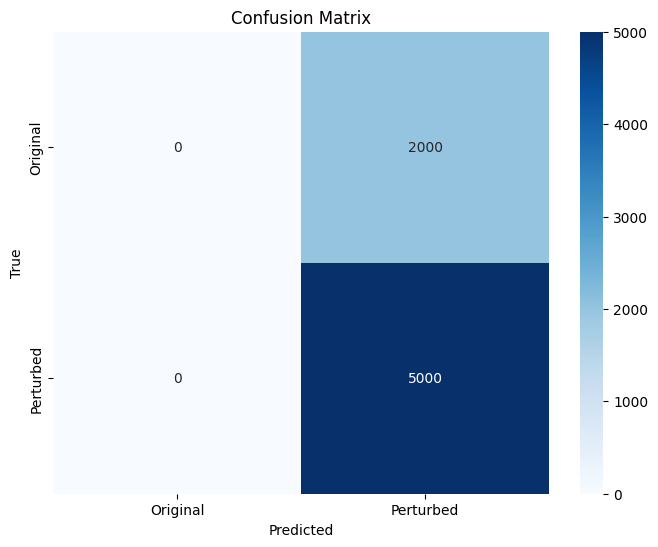


Classification Report:
              precision    recall  f1-score   support

    Original       0.00      0.00      0.00      2000
   Perturbed       0.71      1.00      0.83      5000

    accuracy                           0.71      7000
   macro avg       0.36      0.50      0.42      7000
weighted avg       0.51      0.71      0.60      7000



/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Load original CIFAR-100 test data
(_, _), (original_imgs, _) = tf.keras.datasets.cifar100.load_data()
original_labels = np.zeros(original_imgs.shape[0])  # 0 for original

# Function to load perturbed images
def load_perturbed_images(base_dir, img_size=(32,32)):
    images = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                img = Image.open(os.path.join(root, file))
                img = img.convert('RGB').resize(img_size)
                images.append(np.array(img))
    return np.array(images)

# Load perturbed images from different folders
perturbed_dirs = [
    'differential_evolution',
    'original_one_pixel',
    'sbo_one_pixel',
    'tlmfo',
    'x_pixel'
]

perturbed_images = []
for p_dir in perturbed_dirs:
    p_imgs = load_perturbed_images(p_dir)
    if len(p_imgs) > 0:
        perturbed_images.append(p_imgs)
perturbed_images = np.concatenate(perturbed_images) if perturbed_images else np.empty((0, 32, 32, 3))
perturbed_labels = np.ones(perturbed_images.shape[0])  # 1 for perturbed

# Combine and split datasets
X = np.concatenate([original_imgs, perturbed_images])
y = np.concatenate([original_labels, perturbed_labels])

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Data normalization
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Enhanced data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.8, 1.2]
)

# Improved CNN architecture
model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    
    # Augmentation layers
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.2),
    
    # Feature extraction
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    
    # Deep features
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),
    
    # Classifier
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile with learning rate schedule
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy'])

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

# Calculate proper steps per epoch
batch_size = 64
steps_per_epoch = int(np.ceil(len(X_train) / batch_size))

# Train with class weights
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True),
    epochs=50,
    validation_data=(X_test, y_test),
    steps_per_epoch=steps_per_epoch,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate final performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nFinal Test Accuracy: {test_acc:.4f}')

# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Original', 'Perturbed'], 
           yticklabels=['Original', 'Perturbed'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Original', 'Perturbed']))

In [31]:
# Save the final trained model
model.save('final_model.keras')
print("Model saved as 'final_model.keras'")

Model saved as 'final_model.keras'


Fine tuning on 75k dataset


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Load the entire CIFAR-100 training set
(train_images, _), (_, _) = tf.keras.datasets.cifar100.load_data()
original_imgs = train_images  # Use all 50,000 training images
original_labels = np.zeros(original_imgs.shape[0])  # Label as 0 for original

# Function to load perturbed images
def load_perturbed_images(base_dir, img_size=(32, 32)):
    images = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                img = Image.open(os.path.join(root, file))
                img = img.convert('RGB').resize(img_size)
                images.append(np.array(img))
    return np.array(images)

# Load perturbed images from different folders
perturbed_dirs = [
    'differential_evolution',
    'original_one_pixel',
    'sbo_one_pixel',
    'tlmfo',
    'x_pixel'
]

perturbed_images = []
for p_dir in perturbed_dirs:
    p_imgs = load_perturbed_images(p_dir)
    if len(p_imgs) > 0:
        perturbed_images.append(p_imgs)
perturbed_images = np.concatenate(perturbed_images) if perturbed_images else np.empty((0, 32, 32, 3))
perturbed_labels = np.ones(perturbed_images.shape[0])  # Label as 1 for perturbed

# Combine datasets
X = np.concatenate([original_imgs, perturbed_images])
y = np.concatenate([original_labels, perturbed_labels])

# Normalize images
X = X.astype('float32') / 255.0

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.8, 1.2]
)

# Load the pre-trained model
from tensorflow.keras.models import load_model
model = load_model('final_model.keras')

# Freeze some layers
for layer in model.layers[:-5]:  # Freeze all layers except the last few
    layer.trainable = False

# Recompile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)  # Lower learning rate for fine-tuning
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('fine_tuned_model.keras', save_best_only=True)
]

# Train the model on the updated dataset
batch_size = 64
steps_per_epoch = int(np.ceil(len(X_train) / batch_size))

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True),
    epochs=20,  # Fewer epochs for fine-tuning
    validation_data=(X_test, y_test),
    steps_per_epoch=steps_per_epoch,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate final performance
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nFinal Test Accuracy: {test_acc:.4f}')

# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Original', 'Perturbed'], 
            yticklabels=['Original', 'Perturbed'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_fine_tuned.png')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Original', 'Perturbed']))

# Save the fine-tuned model
model.save('fine_tuned_model_final.keras')
print("Fine-tuned model saved as 'fine_tuned_model_final.keras'")

Epoch 1/20


/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
E0000 00:00:1745741414.273506  101797 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_4_1/dropout_10_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5285 - loss: 0.6935

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth enabled.
Mixed precision training enabled.


I0000 00:00:1745742286.346451  127148 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2609 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
2025-04-27 08:24:46.347945: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 737280000 exceeds 10% of free system memory.
2025-04-27 08:24:47.097559: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 737280000 exceeds 10% of free system memory.


Epoch 1/20


/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 50 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 46 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-04-27 08:24:49.492994: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 737280000 exceeds 10% of free system memory.
E0000 00:00:1745742292.119248  127148 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_

469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.5222 - loss: 0.6940 - val_accuracy: 0.4867 - val_loss: 0.6931
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5078 - loss: 0.6929 - val_accuracy: 0.4775 - val_loss: 0.6937
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.4902 - loss: 0.6951 - val_accuracy: 0.6568 - val_loss: 0.6900
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5076 - loss: 0.6944 - val_accuracy: 0.4885 - val_loss: 0.6940
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.5152 - loss: 0.6931 - val_accuracy: 0.3800 - val_loss: 0.6953
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5137 - loss: 0.6936 - val_accuracy: 0.4603 - val_loss: 0.6953
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.5032 - loss: 0.6933 - val_accuracy: 0.5022 - val_loss: 0.6929
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.4985 - loss: 0.6950 - val_accuracy: 0.61

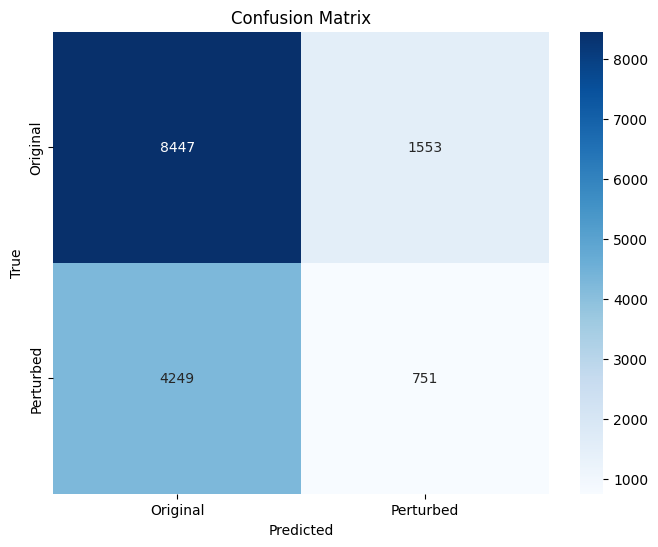


Classification Report:
              precision    recall  f1-score   support

    Original       0.67      0.84      0.74     10000
   Perturbed       0.33      0.15      0.21      5000

    accuracy                           0.61     15000
   macro avg       0.50      0.50      0.48     15000
weighted avg       0.55      0.61      0.56     15000

Fine-tuned model saved as 'fine_tuned_model_final.keras'


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {gpus}")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs detected. Training will run on CPU.")

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision training enabled.")

# Load the entire CIFAR-100 training set
(train_images, _), (_, _) = tf.keras.datasets.cifar100.load_data()
original_imgs = train_images  # Use all 50,000 training images
original_labels = np.zeros(original_imgs.shape[0])  # Label as 0 for original

# Function to load perturbed images
def load_perturbed_images(base_dir, img_size=(32, 32)):
    images = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                img = Image.open(os.path.join(root, file))
                img = img.convert('RGB').resize(img_size)
                images.append(np.array(img))
    return np.array(images)

# Load perturbed images from different folders
perturbed_dirs = [
    'differential_evolution',
    'original_one_pixel',
    'sbo_one_pixel',
    'tlmfo',
    'x_pixel'
]

perturbed_images = []
for p_dir in perturbed_dirs:
    p_imgs = load_perturbed_images(p_dir)
    if len(p_imgs) > 0:
        perturbed_images.append(p_imgs)
perturbed_images = np.concatenate(perturbed_images) if perturbed_images else np.empty((0, 32, 32, 3))
perturbed_labels = np.ones(perturbed_images.shape[0])  # Label as 1 for perturbed

# Combine datasets
X = np.concatenate([original_imgs, perturbed_images])
y = np.concatenate([original_labels, perturbed_labels])

# Normalize images
X = X.astype('float32') / 255.0

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Create TensorFlow datasets for efficient data loading
batch_size = 128  # Larger batch size for GPU
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Load the pre-trained model
from tensorflow.keras.models import load_model
model = load_model('final_model.keras')

# Freeze some layers
for layer in model.layers[:-5]:  # Freeze all layers except the last few
    layer.trainable = False

# Recompile the model with a lower learning rate and mixed precision
optimizer = Adam(learning_rate=0.0001)  # Lower learning rate for fine-tuning
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('fine_tuned_model.keras', save_best_only=True)
]

# Train the model on the updated dataset
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=test_dataset,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate final performance
test_loss, test_acc = model.evaluate(test_dataset)
print(f'\nFinal Test Accuracy: {test_acc:.4f}')

# Generate predictions
y_pred = (model.predict(X_test, batch_size=batch_size) > 0.5).astype(int)

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Original', 'Perturbed'], 
            yticklabels=['Original', 'Perturbed'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_fine_tuned.png')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Original', 'Perturbed']))

# Save the fine-tuned model
model.save('fine_tuned_model_final.keras')
print("Fine-tuned model saved as 'fine_tuned_model_final.keras'")

further fine tune

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth enabled.
Mixed precision training enabled.


2025-04-27 08:34:43.783429: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 737280000 exceeds 10% of free system memory.
2025-04-27 08:34:44.404617: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 737280000 exceeds 10% of free system memory.


Epoch 1/30


E0000 00:00:1745742888.261402  127148 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_4_1/dropout_10_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.4948 - loss: 0.6955 - val_accuracy: 0.5345 - val_loss: 0.6930
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.4982 - loss: 0.6943 - val_accuracy: 0.4157 - val_loss: 0.6941
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5042 - loss: 0.6933 - val_accuracy: 0.4637 - val_loss: 0.6938
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5044 - loss: 0.6953 - val_accuracy: 0.4694 - val_loss: 0.6936
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5034 - loss: 0.6941 - val_accuracy: 0.4978 - val_loss: 0.6935
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5124 - loss: 0.6920 - val_accuracy: 0.5047 - val_loss: 0.6938
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5141 - loss: 0.6926 - val_accuracy: 0.5376 - val_loss: 0.6934
Epoch 8/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5057 - loss: 0.6918 - val_accuracy: 0.514

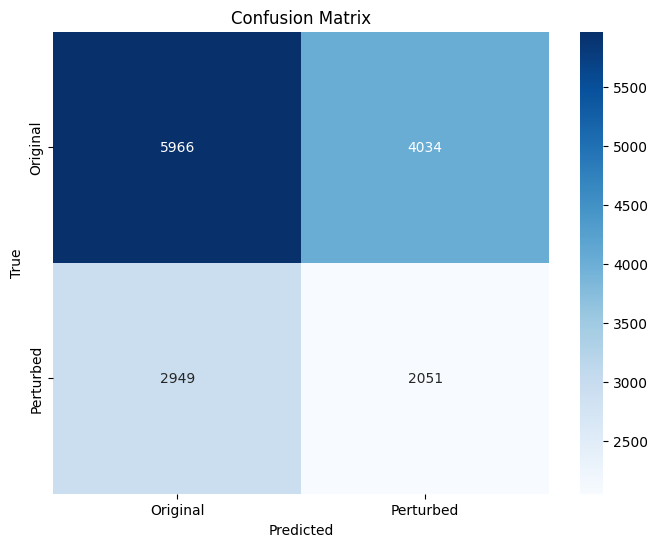


Classification Report:
              precision    recall  f1-score   support

    Original       0.67      0.60      0.63     10000
   Perturbed       0.34      0.41      0.37      5000

    accuracy                           0.53     15000
   macro avg       0.50      0.50      0.50     15000
weighted avg       0.56      0.53      0.54     15000

Fine-tuned model saved as 'fine_tuned_model_updated.keras'


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {gpus}")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs detected. Training will run on CPU.")

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision training enabled.")

# Load the entire CIFAR-100 training set
(train_images, _), (_, _) = tf.keras.datasets.cifar100.load_data()
original_imgs = train_images  # Use all 50,000 training images
original_labels = np.zeros(original_imgs.shape[0])  # Label as 0 for original

# Function to load perturbed images
def load_perturbed_images(base_dir, img_size=(32, 32)):
    images = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                img = Image.open(os.path.join(root, file))
                img = img.convert('RGB').resize(img_size)
                images.append(np.array(img))
    return np.array(images)

# Load perturbed images from different folders
perturbed_dirs = [
    'differential_evolution',
    'original_one_pixel',
    'sbo_one_pixel',
    'tlmfo',
    'x_pixel'
]

perturbed_images = []
for p_dir in perturbed_dirs:
    p_imgs = load_perturbed_images(p_dir)
    if len(p_imgs) > 0:
        perturbed_images.append(p_imgs)
perturbed_images = np.concatenate(perturbed_images) if perturbed_images else np.empty((0, 32, 32, 3))
perturbed_labels = np.ones(perturbed_images.shape[0])  # Label as 1 for perturbed

# Combine datasets
X = np.concatenate([original_imgs, perturbed_images])
y = np.concatenate([original_labels, perturbed_labels])

# Normalize images
X = X.astype('float32') / 255.0

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Create TensorFlow datasets for efficient data loading
batch_size = 256  # Larger batch size for GPU
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Load the previously trained model
from tensorflow.keras.models import load_model
model = load_model('fine_tuned_model_final.keras')

# Freeze some layers
for layer in model.layers[:-10]:  # Freeze all layers except the last few
    layer.trainable = False

# Recompile the model with a lower learning rate and mixed precision
optimizer = Adam(learning_rate=0.00005)  # Lower learning rate for fine-tuning
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('fine_tuned_model_updated.keras', save_best_only=True)
]

# Train the model on the updated dataset
history = model.fit(
    train_dataset,
    epochs=30,  # Increase epochs
    validation_data=test_dataset,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate final performance
test_loss, test_acc = model.evaluate(test_dataset)
print(f'\nFinal Test Accuracy: {test_acc:.4f}')

# Generate predictions
y_pred = (model.predict(X_test, batch_size=batch_size) > 0.5).astype(int)

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Original', 'Perturbed'], 
            yticklabels=['Original', 'Perturbed'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_fine_tuned_updated.png')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Original', 'Perturbed']))

# Save the fine-tuned model
model.save('fine_tuned_model_updated.keras')
print("Fine-tuned model saved as 'fine_tuned_model_updated.keras'")

Subset Selection

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth enabled.
Mixed precision training enabled.
Epoch 1/30


E0000 00:00:1745743555.244245  127148 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_4_1/dropout_10_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5015 - loss: 0.6934 - val_accuracy: 0.4955 - val_loss: 0.6930
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4965 - loss: 0.6935 - val_accuracy: 0.5034 - val_loss: 0.6930
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5019 - loss: 0.6933 - val_accuracy: 0.5007 - val_loss: 0.6931
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4980 - loss: 0.6934 - val_accuracy: 0.5065 - val_loss: 0.6931
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5006 - loss: 0.6933 - val_accuracy: 0.5004 - val_loss: 0.6932
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4990 - loss: 0.6934 - val_accuracy: 0.5021 - val_loss: 0.6932
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5070 - loss: 0.6932 - val_accuracy: 0.5051 - val_loss: 0.6931
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4988 - loss: 0.6933 - val_accuracy: 0.497

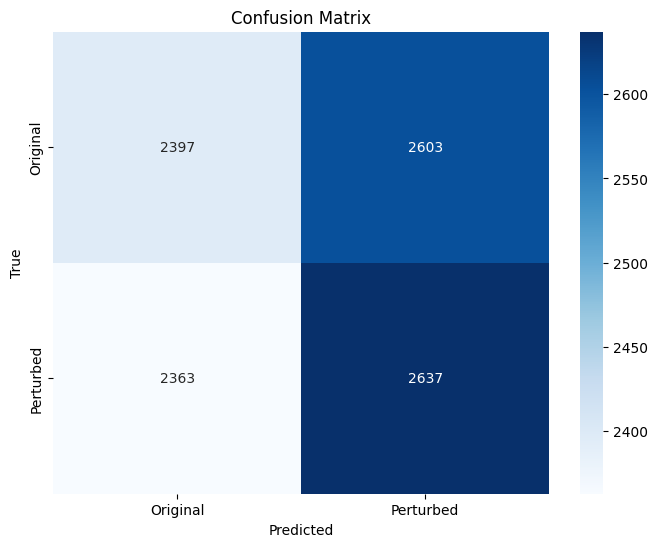


Classification Report:
              precision    recall  f1-score   support

    Original       0.50      0.48      0.49      5000
   Perturbed       0.50      0.53      0.52      5000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000

Fine-tuned model saved as 'fine_tuned_model_updated.keras'


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {gpus}")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs detected. Training will run on CPU.")

# Enable mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision training enabled.")

# Load CIFAR-100 training set
(train_images, _), (_, _) = tf.keras.datasets.cifar100.load_data()
original_imgs = train_images
original_labels = np.zeros(original_imgs.shape[0])

# Function to load perturbed images
def load_perturbed_images(base_dir, img_size=(32, 32)):
    images = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                img = Image.open(os.path.join(root, file))
                img = img.convert('RGB').resize(img_size)
                images.append(np.array(img))
    return np.array(images)

# Load perturbed images from different folders
perturbed_dirs = [
    'differential_evolution',
    'original_one_pixel',
    'sbo_one_pixel',
    'tlmfo',
    'x_pixel'
]

perturbed_images = []
for p_dir in perturbed_dirs:
    p_imgs = load_perturbed_images(p_dir)
    if len(p_imgs) > 0:
        perturbed_images.append(p_imgs)
perturbed_images = np.concatenate(perturbed_images) if perturbed_images else np.empty((0, 32, 32, 3))
perturbed_labels = np.ones(perturbed_images.shape[0])  # Label as 1 for perturbed

# Select an optimal subset of original images
num_perturbed = perturbed_images.shape[0]  # Number of perturbed images
subset_size = min(num_perturbed, original_imgs.shape[0])  # Match the number of perturbed images

# Randomly sample original images
indices = np.random.choice(original_imgs.shape[0], size=subset_size, replace=False)
original_imgs_subset = original_imgs[indices]
original_labels_subset = original_labels[indices]

# Combine datasets
X = np.concatenate([original_imgs_subset, perturbed_images])
y = np.concatenate([original_labels_subset, perturbed_labels])

# Normalize images
X = X.astype('float32') / 255.0

# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Create TensorFlow datasets for efficient data loading
batch_size = 128  # Larger batch size for GPU
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Load the previously trained model
from tensorflow.keras.models import load_model
model = load_model('fine_tuned_model_final.keras')

# Freeze some layers
for layer in model.layers[:-10]:  # Freeze all layers except the last few
    layer.trainable = False

# Recompile the model with a lower learning rate and mixed precision
optimizer = Adam(learning_rate=0.00005)  # Lower learning rate for fine-tuning
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('fine_tuned_model_updated.keras', save_best_only=True)
]

# Train the model on the updated dataset
history = model.fit(
    train_dataset,
    epochs=30,  # Increase epochs
    validation_data=test_dataset,
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate final performance
test_loss, test_acc = model.evaluate(test_dataset)
print(f'\nFinal Test Accuracy: {test_acc:.4f}')

# Generate predictions
y_pred = (model.predict(X_test, batch_size=batch_size) > 0.5).astype(int)

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Original', 'Perturbed'], 
            yticklabels=['Original', 'Perturbed'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_fine_tuned_updated.png')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Original', 'Perturbed']))

# Save the fine-tuned model
model.save('fine_tuned_model_updated.keras')
print("Fine-tuned model saved as 'fine_tuned_model_updated.keras'")

updated architecure

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/50


/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745744206.868382  127220 service.cc:152] XLA service 0x565250301020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745744206.868413  127220 service.cc:160]   StreamExecutor device (0): NVIDIA TITAN Xp, Compute Capability 6.1
2025-04-27 08:56:47.610631: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  3/625 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.3837 - loss: 0.8565   

I0000 00:00:1745744220.639201  127220 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 94ms/step - accuracy: 0.4968 - loss: 0.7055 - val_accuracy: 0.5000 - val_loss: 0.6945
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.4989 - loss: 0.6938 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.4961 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.4985 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - accuracy: 0.4933 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.4969 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.4976 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.5014 - loss: 0.6931 - val_accurac

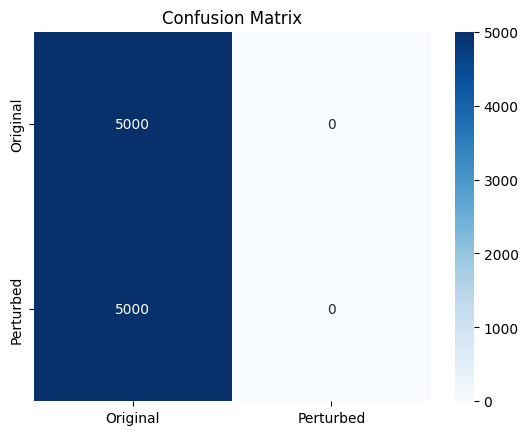

/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

              precision    recall  f1-score   support

    Original       0.50      1.00      0.67      5000
   Perturbed       0.00      0.00      0.00      5000

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Check for GPU availability [[5]]
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {gpus}")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs detected. Training will run on CPU.")

# Enable mixed precision training [[5]]
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Load CIFAR-100 training set
(train_images, _), (_, _) = tf.keras.datasets.cifar100.load_data()
original_imgs = train_images
original_labels = np.zeros(original_imgs.shape[0])

# Function to load perturbed images
def load_perturbed_images(base_dir, img_size=(32, 32)):
    images = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                img = Image.open(os.path.join(root, file))
                img = img.convert('RGB').resize(img_size)
                images.append(np.array(img))
    return np.array(images)

# Load perturbed images from folders
perturbed_dirs = [
    'differential_evolution',
    'original_one_pixel',
    'sbo_one_pixel',
    'tlmfo',
    'x_pixel'
]

perturbed_images = []
for p_dir in perturbed_dirs:
    p_imgs = load_perturbed_images(p_dir)
    if len(p_imgs) > 0:
        perturbed_images.append(p_imgs)
perturbed_images = np.concatenate(perturbed_images) if perturbed_images else np.empty((0, 32, 32, 3))
perturbed_labels = np.ones(perturbed_images.shape[0])  # 1 for perturbed

# Balance dataset [[3]]
num_perturbed = perturbed_images.shape[0]
indices = np.random.choice(original_imgs.shape[0], size=num_perturbed, replace=False)
original_imgs = original_imgs[indices]
original_labels = original_labels[indices]

# Combine datasets
X = np.concatenate([original_imgs, perturbed_images])
y = np.concatenate([original_labels, perturbed_labels])

# Normalize images [[7]]
X = X.astype('float32') / 255.0

# Split data [[6]]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Advanced data augmentation [[9]]
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Load EfficientNetB0 [[9]]
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(32, 32, 3),
    weights='imagenet'
)

# Freeze base layers [[5]]
base_model.trainable = False

# Build model [[6]]
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile with class weights [[3]]
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

# Train with augmented data [[8]]
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=callbacks
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Final Test Accuracy: {test_acc:.4f}')

# Confusion matrix [[7]]
y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Original', 'Perturbed'], 
            yticklabels=['Original', 'Perturbed'])
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=['Original', 'Perturbed']))

# Save model
model.save('perturbation_detector.keras')

Epoch 1/10


2025-04-27 09:14:35.099384: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.6 = (f16[128,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f16[128,3,32,32]{3,2,1,0} %bitcast.2814, f16[32,3,3,3]{3,2,1,0} %bitcast.2659, f16[32]{0} %bitcast.2662), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_1/convolution" source_file="/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-27 09:14:35.140910: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:

464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5137 - loss: 0.6960

2025-04-27 09:14:39.839966: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.6 = (f16[96,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f16[96,3,32,32]{3,2,1,0} %bitcast.2814, f16[32,3,3,3]{3,2,1,0} %bitcast.2659, f16[32]{0} %bitcast.2662), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_1/convolution" source_file="/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-27 09:14:39.874636: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:54

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5140 - loss: 0.6960

2025-04-27 09:14:42.063772: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.6 = (f16[128,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f16[128,3,32,32]{3,2,1,0} %bitcast.373, f16[32,3,3,3]{3,2,1,0} %bitcast.381, f16[32]{0} %bitcast.384), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_1/convolution" source_file="/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-27 09:14:42.098590: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.5140 - loss: 0.6960 - val_accuracy: 0.5721 - val_loss: 0.6908
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5327 - loss: 0.6920 - val_accuracy: 0.3743 - val_loss: 0.7093
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5374 - loss: 0.6879 - val_accuracy: 0.4589 - val_loss: 0.7056
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5800 - loss: 0.6687 - val_accuracy: 0.5897 - val_loss: 0.6877
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7394 - loss: 0.5619 - val_accuracy: 0.8407 - val_loss: 0.4064
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8592 - loss: 0.3852 - val_accuracy: 0.8632 - val_loss: 0.3707
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9037 - loss: 0.2935 - val_accuracy: 0.8879 - val_loss: 0.3140
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9158 - loss: 0.2554 - val_accuracy: 0.9097 - va

2025-04-27 09:15:14.115717: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.6 = (f16[32,32,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,3,32,32]{3,2,1,0} %bitcast.222, f16[32,3,3,3]{3,2,1,0} %bitcast.230, f16[32]{0} %bitcast.233), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_1/convolution" source_file="/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-27 09:15:14.143270: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] 

469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


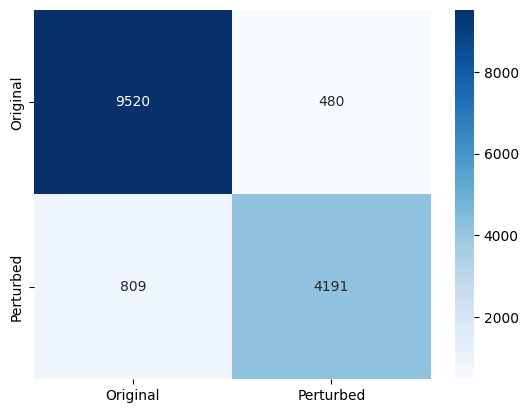


Classification Report:
              precision    recall  f1-score   support

    Original       0.92      0.95      0.94     10000
   Perturbed       0.90      0.84      0.87      5000

    accuracy                           0.91     15000
   macro avg       0.91      0.90      0.90     15000
weighted avg       0.91      0.91      0.91     15000



In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Load CIFAR-100 training set
(train_images, _), (_, _) = tf.keras.datasets.cifar100.load_data()
original_imgs = train_images
original_labels = np.zeros(original_imgs.shape[0])

# Function to load perturbed images
def load_perturbed_images(base_dir, img_size=(32, 32)):
    images = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                img = Image.open(os.path.join(root, file))
                img = img.convert('RGB').resize(img_size)
                images.append(np.array(img))
    return np.array(images)

# Load perturbed images from different folders
perturbed_dirs = [
    'differential_evolution',
    'original_one_pixel',
    'sbo_one_pixel',
    'tlmfo',
    'x_pixel'
]

perturbed_images = []
for p_dir in perturbed_dirs:
    p_imgs = load_perturbed_images(p_dir)
    if len(p_imgs) > 0:
        perturbed_images.append(p_imgs)
    else:
        print(f"Warning: No images found in {p_dir}")

if not perturbed_images:
    raise ValueError("No perturbed images loaded! Check directory paths.")
perturbed_images = np.concatenate(perturbed_images)
perturbed_labels = np.ones(perturbed_images.shape[0])

# Combine datasets
X = np.concatenate([original_imgs, perturbed_images])
y = np.concatenate([original_labels, perturbed_labels])

# Normalize images
X = X.astype('float32') / 255.0

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Calculate class weights [[4]]
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Create TensorFlow datasets [[6]]
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build CNN model [[9]]
model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile with Adam optimizer [[2]]
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model [[5]]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    class_weight=class_weights
)

# Evaluate final performance
test_loss, test_acc = model.evaluate(test_dataset)
print(f'\nFinal Test Accuracy: {test_acc:.4f}')

# Confusion matrix visualization
y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Original', 'Perturbed'], 
            yticklabels=['Original', 'Perturbed'])
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Original', 'Perturbed']))

Removal Pertubation

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


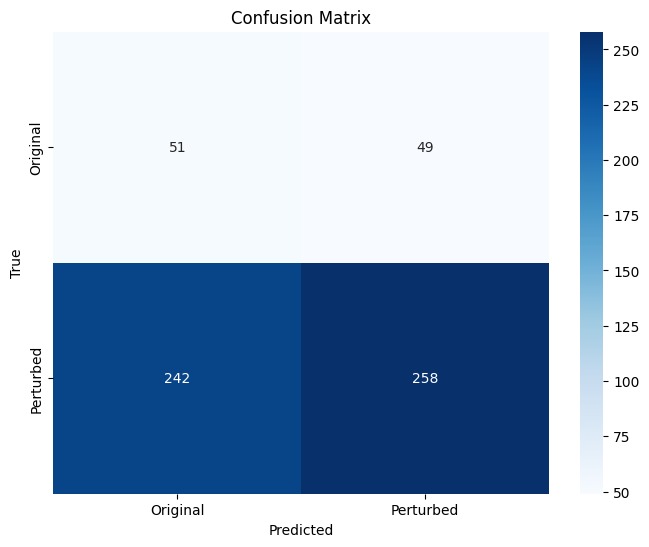


Classification Report:
              precision    recall  f1-score   support

    Original       0.17      0.51      0.26       100
   Perturbed       0.84      0.52      0.64       500

    accuracy                           0.52       600
   macro avg       0.51      0.51      0.45       600
weighted avg       0.73      0.52      0.58       600



In [10]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Function to load images from a directory (up to 100 images)
def load_images_from_dir(directory, img_size=(32, 32), max_count=100):
    images = []
    count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')) and count < max_count:
                img_path = os.path.join(root, file)
                img = Image.open(img_path).convert('RGB').resize(img_size)
                images.append(np.array(img))
                count += 1
            if count >= max_count:
                break
        if count >= max_count:
            break
    return np.array(images)

# List of perturbation folders
perturbation_folders = [
    'differential_evolution',
    'original_one_pixel',
    'sbo_one_pixel',
    'tlmfo',
    'x_pixel'
]

# Load 100 images from each perturbation folder
perturbed_images = []
for folder in perturbation_folders:
    imgs = load_images_from_dir(folder)
    perturbed_images.append(imgs)
perturbed_images = np.concatenate(perturbed_images)
perturbed_labels = np.ones(len(perturbed_images))  # Label as 1 (Perturbed)

# Load 100 original CIFAR-100 images
(_, _), (original_imgs, _) = tf.keras.datasets.cifar100.load_data()
original_imgs = original_imgs[:100]  # Select first 100 images
original_labels = np.zeros(len(original_imgs))  # Label as 0 (Original)

# Combine datasets
X = np.concatenate([original_imgs, perturbed_images])
y = np.concatenate([original_labels, perturbed_labels])

# Normalize images
X = X.astype('float32') / 255.0

# Load the trained model
model = load_model('final_fine_tuned_model_updated.keras')

# Make predictions
y_pred = (model.predict(X) > 0.5).astype(int)

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Original', 'Perturbed'], 
            yticklabels=['Original', 'Perturbed'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_test.png')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=['Original', 'Perturbed']))

This is part below where the attacked pixel is getting removed and here i have tried to implement the 3-4 diffrent method to detect the attacked pixel and then rectify the attack

Detection+Removal

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
import cv2

# ---------------------------
# Load the trained model
# ---------------------------
model = load_model('final_fine_tuned_model_updated.keras')

# ---------------------------
# Utility: Load & preprocess
# ---------------------------
def load_and_preprocess_image(image_path):
    """Load and preprocess an image (resize + normalize)."""
    img = Image.open(image_path).convert('RGB')
    img = img.resize((32, 32))
    img_array = np.array(img) / 255.0
    return img_array

# ---------------------------
# Detect perturbed image
# ---------------------------
def detect_perturbation(image):
    """Classify image as perturbed (1) or original (0)."""
    prediction = model.predict(np.expand_dims(image, axis=0))[0][0]
    return 1 if prediction > 0.5 else 0

# =====================================================
# Defense Methods (based on different research papers)
# =====================================================

def defense_feature_squeezing(image):
    """
    Defense 1: Feature Squeezing (Xu et al., ICLR 2018)
    - Apply bit-depth reduction + median filtering.
    """
    # Reduce bit depth to 4 bits (quantization)
    squeezed = np.floor(image * 15) / 15.0
    
    # Apply 3x3 median filter to smooth out isolated pixel noise
    filtered = median_filter(squeezed, size=(3, 3, 1))
    
    return filtered

def defense_pixel_deflection(image, num_deflections=10, window_size=3):
    """
    Defense 2: Pixel Deflection (Prakash et al., CVPR 2018)
    - Randomly replace suspicious pixels with nearby neighbors
    - Then apply a smoothing filter
    """
    deflected = image.copy()
    h, w, c = deflected.shape
    
    for _ in range(num_deflections):
        # Pick a random pixel
        x, y = np.random.randint(0, h), np.random.randint(0, w)
        
        # Pick a random neighbor within window
        dx, dy = np.random.randint(-window_size, window_size+1, size=2)
        nx, ny = np.clip(x+dx, 0, h-1), np.clip(y+dy, 0, w-1)
        
        # Replace with neighbor
        deflected[x, y] = deflected[nx, ny]
    
    # Apply median filter for smoothing
    smoothed = median_filter(deflected, size=(3, 3, 1))
    return smoothed

def defense_jpeg_compression(image, quality=75):
    """
    Defense 3: JPEG Compression (Das et al., 2018 - Shield)
    - Save and reload image with JPEG compression
    - Removes high-frequency adversarial perturbations
    """
    img_uint8 = (image * 255).astype(np.uint8)
    _, encoded_img = cv2.imencode('.jpg', cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR), [int(cv2.IMWRITE_JPEG_QUALITY), quality])
    decoded_img = cv2.imdecode(encoded_img, 1)
    decoded_img = cv2.cvtColor(decoded_img, cv2.COLOR_BGR2RGB)
    return decoded_img / 255.0

def defense_randomization(image):
    """
    Defense 4: Randomization (Xie et al., ICLR 2018)
    - Random resize + random padding
    - Breaks exact pixel-location dependency of adversarial attack
    """
    img_uint8 = (image * 255).astype(np.uint8)
    
    # Random resize
    rand_size = np.random.randint(28, 36)  # resize to [28,36]
    resized = cv2.resize(img_uint8, (rand_size, rand_size))
    
    # Random padding to get back to 32x32
    top = np.random.randint(0, 32 - rand_size)
    left = np.random.randint(0, 32 - rand_size)
    padded = np.zeros((32, 32, 3), dtype=np.uint8)
    padded[top:top+rand_size, left:left+rand_size] = resized
    
    return padded / 255.0

# ---------------------------
# Choose which defense to apply
# ---------------------------
def remove_perturbation(image, method="feature_squeezing"):
    """
    Wrapper function to apply chosen defense method.
    Available methods: "feature_squeezing", "pixel_deflection", "jpeg", "randomization"
    """
    if method == "feature_squeezing":
        return defense_feature_squeezing(image)
    elif method == "pixel_deflection":
        return defense_pixel_deflection(image)
    elif method == "jpeg":
        return defense_jpeg_compression(image)
    elif method == "randomization":
        return defense_randomization(image)
    else:
        raise ValueError("Unknown defense method: choose from 'feature_squeezing', 'pixel_deflection', 'jpeg', 'randomization'")

# ---------------------------
# Pipeline: Process images
# ---------------------------
def process_images(input_dir, output_dir, defense_method="feature_squeezing"):
    """Process all images in a directory using chosen defense."""
    os.makedirs(output_dir, exist_ok=True)
    
    for filename in os.listdir(input_dir):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(input_dir, filename)
            try:
                # Load and preprocess image
                img = load_and_preprocess_image(image_path)
                
                # Detect perturbation
                is_perturbed = detect_perturbation(img)
                
                if is_perturbed:
                    print(f"Processing perturbed image: {filename} with {defense_method}")
                    
                    # Apply chosen defense
                    cleaned_img = remove_perturbation(img, method=defense_method)
                    
                    # Save processed image
                    plt.imsave(os.path.join(output_dir, filename), cleaned_img)
                else:
                    print(f"Original image: {filename} (no processing needed)")
                    plt.imsave(os.path.join(output_dir, filename), img)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
Original image: differential_evolution_2930.png (no processing needed)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Processing perturbed image: differential_evolution_2789.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Processing perturbed image: differential_evolution_4790.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Processing perturbed image: differential_evolution_2055.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Processing perturbed image: differential_evolution_1398.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Processing perturbed image: differential_evolution_1951.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Original image: differential_evolution_3870.png (no processing needed)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Original image: differential_evolution_3935.png (no processing needed)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Processing perturbed image: differential_evolution_510.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Processing perturbed image: differential_evolut

GAN


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
# Assuming non-local means is best
def best_perturbation_removal(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)


In [28]:
# Assuming non-local means is best
def best_perturbation_removal(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)


In [29]:
class CustomImageDataset(Dataset):
    def __init__(self, perturbed_dir, original_dir, num_samples=5):
        self.perturbed_dir = perturbed_dir
        self.original_dir = original_dir
        
        # Pick random 5 images
        self.files = random.sample(os.listdir(perturbed_dir), num_samples)
        
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        perturbed_path = os.path.join(self.perturbed_dir, self.files[idx])
        original_path = os.path.join(self.original_dir, self.files[idx])  # Assuming filenames match
        
        # Read images
        perturbed_img = cv2.imread(perturbed_path)
        original_img = cv2.imread(original_path)
        
        # Apply best perturbation removal
        cleaned_img = best_perturbation_removal(perturbed_img)
        
        # Convert BGR to RGB
        cleaned_img = cv2.cvtColor(cleaned_img, cv2.COLOR_BGR2RGB)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        
        # Transform to Tensor
        cleaned_tensor = self.transform(cleaned_img)
        original_tensor = self.transform(original_img)
        
        return cleaned_tensor, original_tensor


In [30]:
# Residual Block for Generator
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels)
        )
    def forward(self, x):
        return x + self.block(x)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.entry = nn.Sequential(
            nn.Conv2d(3, 64, 9, padding=4),
            nn.ReLU(inplace=True)
        )
        self.residuals = nn.Sequential(
            *[ResidualBlock(64) for _ in range(5)]
        )
        self.exit = nn.Sequential(
            nn.Conv2d(64, 3, 9, padding=4),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.entry(x)
        x = self.residuals(x)
        x = self.exit(x)
        return x

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = CustomImageDataset('differential_evolution', 'original_image', num_samples=5)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

G = Generator().to(device)
D = Discriminator().to(device)

opt_G = optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))
criterion = nn.BCELoss()
pixelwise_loss = nn.L1Loss()


In [33]:
import torch
import torch.optim as optim
import torch.nn as nn
import cv2  # OpenCV for image processing

num_epochs = 20  # Train longer since model is deeper

# Assuming `G`, `D`, `criterion`, `opt_D`, `opt_G`, `pixelwise_loss`, and `loader` are already defined
for epoch in range(num_epochs):
    G.train()
    D.train()
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        real_labels = torch.ones(len(inputs), 1).to(device)
        fake_labels = torch.zeros(len(inputs), 1).to(device)
        
        # 1. Train Discriminator
        D.zero_grad()
        real_outputs = D(targets)
        loss_real = criterion(real_outputs, real_labels)
        
        fake_images = G(inputs)
        
        # Check if generated image is valid before passing to Discriminator
        if fake_images is not None and fake_images.size(0) > 0:
            fake_outputs = D(fake_images.detach())
            loss_fake = criterion(fake_outputs, fake_labels)
        else:
            print("Generated fake images are empty!")
            continue
        
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        opt_D.step()
        
        # 2. Train Generator
        G.zero_grad()
        
        # Check if fake images are valid before passing to Discriminator
        if fake_images is not None and fake_images.size(0) > 0:
            fake_outputs = D(fake_images)
            loss_GAN = criterion(fake_outputs, real_labels)
        else:
            print("Generated fake images are empty!")
            continue
        
        # Check if pixelwise loss is valid
        if fake_images is not None and targets is not None:
            loss_pixel = pixelwise_loss(fake_images, targets)
        else:
            print("Pixelwise loss: Invalid image data!")
            continue
        
        loss_G = loss_GAN + 100 * loss_pixel  # Balance GAN loss and pixel accuracy
        loss_G.backward()
        opt_G.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss_D: {loss_D.item():.4f}  Loss_G: {loss_G.item():.4f}")  

    # Optionally, you can add checks to see if any image is empty before OpenCV processing
    if fake_images is not None and fake_images.size(0) > 0:
        fake_images_np = fake_images[0].cpu().detach().numpy()
        if fake_images_np is not None and fake_images_np.size > 0:
            # Assuming you're using OpenCV to process images
            try:
                fake_image_color = cv2.cvtColor(fake_images_np, cv2.COLOR_RGB2BGR)
                # Your OpenCV image processing code here
            except cv2.error as e:
                print(f"OpenCV error: {e}")
        else:
            print("Fake image is empty or invalid")


[ WARN:0@1036.711] global loadsave.cpp:268 findDecoder imread_('original_image/differential_evolution_3305.png'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

2025-04-28 18:48:23.672065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745866103.693847  461055 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745866103.700438  461055 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745866103.717458  461055 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745866103.717491  461055 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745866103.717495  461055 computation_placer.cc:177] computation placer alr

In [2]:
# Define paths
original_folder = "original_images"
perturbed_folder = "differential_evolution"

# Function to load and preprocess images
def load_images(folder_path, img_size=(32, 32)):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img = tf.keras.preprocessing.image.load_img(
                os.path.join(folder_path, filename),
                target_size=img_size
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img_array / 127.5 - 1)  # Normalize to [-1, 1]
    return np.array(images)

# Load original and perturbed images
original_images = load_images(original_folder)
perturbed_images = load_images(perturbed_folder)

# Combine datasets
X_train = np.concatenate([original_images, perturbed_images])

# Shuffle the dataset
np.random.shuffle(X_train)
print(f"Total training images: {len(X_train)}")

Total training images: 10000


In [3]:
def build_generator(latent_dim):
    model = models.Sequential()

    # Input layer (latent vector)
    model.add(layers.Dense(4 * 4 * 256, input_dim=latent_dim))
    model.add(layers.Reshape((4, 4, 256)))

    # Upsampling layers
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Output layer
    model.add(layers.Conv2D(3, kernel_size=3, padding='same', activation='tanh'))

    return model

In [4]:
def build_discriminator(img_shape):
    model = models.Sequential()

    # Input layer
    model.add(layers.Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=img_shape))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [5]:
# Latent dimension for the generator
latent_dim = 100

# Build the generator and discriminator
generator = build_generator(latent_dim)
discriminator = build_discriminator(img_shape=(32, 32, 3))

# Compile the discriminator
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Freeze the discriminator for the GAN
discriminator.trainable = False

# Build the GAN by combining generator and discriminator
gan_input = layers.Input(shape=(latent_dim,))
fake_image = generator(gan_input)
gan_output = discriminator(fake_image)

gan = models.Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
            loss='binary_crossentropy')

/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745866201.563752  461055 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11363 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/Su

In [6]:
# Training parameters
epochs = 10000
batch_size = 64
sample_interval = 100

# Labels for real and fake images
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

for epoch in range(epochs):
    # Sample real images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_images = X_train[idx]

    # Generate fake images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_images = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator (via the GAN model)
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, real_labels)

    # Print progress
    if epoch % sample_interval == 0:
        print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

        # Save generated images
        save_generated_images(generator, epoch)

I0000 00:00:1745866203.408358  461263 service.cc:152] XLA service 0x7f56d40047f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745866203.408388  461263 service.cc:160]   StreamExecutor device (0): NVIDIA TITAN Xp, Compute Capability 6.1
2025-04-28 18:50:03.431612: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745866203.563638  461263 cuda_dnn.cc:529] Loaded cuDNN version 90600
2025-04-28 18:50:04.124981: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.3 = (f32[32,3,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,32,32]{3,2,1,0} %bitcast.440, f32[3,32,3,3]{3,2,1,0} %bitcast.447, f32[3]{0} %bitcast.449), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActi

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


I0000 00:00:1745866204.590888  461263 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
2025-04-28 18:50:10.050509: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.19 = (f32[64,3,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,32,32]{3,2,1,0} %bitcast.7839, f32[3,32,3,3]{3,2,1,0} %bitcast.6294, f32[3]{0} %bitcast.7899), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_26_1/sequential_1/conv2d_1/convolution" source_file="/home/Suvit_BE/.local/share/v

0 [D loss: 0.7026, acc.: 32.81%] [G loss: 0.7025]


NameError: name 'save_generated_images' is not defined

In [ ]:
def save_generated_images(generator, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    generated_images = generator.predict(noise)

    # Rescale images to [0, 1]
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.savefig(f"generated_images_epoch_{epoch}.png")
    plt.close()

In [ ]:
# Save the generator and discriminator models
generator.save('gan_generator.h5')
discriminator.save('gan_discriminator.h5')

print("Generator and Discriminator models saved successfully.")

In [ ]:
# Save the entire GAN
gan.save('gan_combined.h5')
print("Combined GAN model saved successfully.")

GAN updated

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define paths
original_folder = "original_images"
perturbed_folder = "differential_evolution"

# Check if folders exist
if not os.path.exists(original_folder) or not os.path.exists(perturbed_folder):
    raise FileNotFoundError(f"Please create the folders '{original_folder}' and '{perturbed_folder}' and add images.")

# Function to load and preprocess images
def load_images(folder_path, img_size=(32, 32)):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img = tf.keras.preprocessing.image.load_img(
                os.path.join(folder_path, filename),
                target_size=img_size
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img_array / 127.5 - 1)  # Normalize to [-1, 1]
    return np.array(images)

# Load original and perturbed images
original_images = load_images(original_folder)
perturbed_images = load_images(perturbed_folder)

# Combine datasets
X_train = np.concatenate([original_images, perturbed_images])

# Labels: 0 for original, 1 for perturbed
y_train = np.concatenate([np.zeros(len(original_images)), np.ones(len(perturbed_images))])

# Shuffle the dataset
shuffle_indices = np.random.permutation(len(X_train))
X_train = X_train[shuffle_indices]
y_train = y_train[shuffle_indices]

print(f"Total training images: {len(X_train)}")

# Build the generator
def build_generator(latent_dim):
    model = models.Sequential()

    # Input layer (latent vector + label)
    model.add(layers.InputLayer(input_shape=(latent_dim + 1,)))  # +1 for the label
    model.add(layers.Dense(4 * 4 * 256))
    model.add(layers.Reshape((4, 4, 256)))

    # Upsampling layers
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Output layer
    model.add(layers.Conv2D(3, kernel_size=3, padding='same', activation='tanh'))

    return model

# Build the discriminator
def build_discriminator(img_shape):
    model = models.Sequential()

    # Input layer (image + label)
    model.add(layers.InputLayer(input_shape=img_shape))  # Image input
    model.add(layers.Conv2D(32, kernel_size=3, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

    return model

# Latent dimension for the generator
latent_dim = 100

# Build the generator and discriminator
generator = build_generator(latent_dim)
discriminator = build_discriminator(img_shape=(32, 32, 3))

# Compile the discriminator
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Freeze the discriminator for the GAN
discriminator.trainable = False

# Build the GAN by combining generator and discriminator
gan_input = layers.Input(shape=(latent_dim + 1,))  # Latent vector + label
fake_image = generator(gan_input)
gan_output = discriminator(fake_image)

gan = models.Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
            loss='binary_crossentropy')

# Function to save generated images
def save_generated_images(generator, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    labels = np.random.randint(0, 2, size=(examples, 1))  # Random labels for normal/perturbed
    noise_with_labels = np.hstack([noise, labels])  # Concatenate noise and labels
    generated_images = generator.predict(noise_with_labels)

    # Rescale images to [0, 1]
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.savefig(f"generated_images_epoch_{epoch}.png")
    plt.close()

# Training parameters
epochs = 10000
batch_size = 64
sample_interval = 100

# Labels for real and fake images
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

for epoch in range(epochs):
    # Sample real images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_images = X_train[idx]
    real_image_labels = y_train[idx].reshape(-1, 1)  # Get corresponding labels

    # Generate fake images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_image_labels = np.random.randint(0, 2, size=(batch_size, 1))  # Random labels for fake images
    noise_with_labels = np.hstack([noise, fake_image_labels])  # Concatenate noise and labels
    fake_images = generator.predict(noise_with_labels)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch([real_images, real_image_labels], real_labels)
    d_loss_fake = discriminator.train_on_batch([fake_images, fake_image_labels], fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator (via the GAN model)
    misleading_labels = np.ones((batch_size, 1))  # Generator tries to fool the discriminator
    g_loss = gan.train_on_batch(noise_with_labels, misleading_labels)

    # Print progress
    if epoch % sample_interval == 0:
        print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")

        # Save generated images
        save_generated_images(generator, epoch)

# Save the generator and discriminator
generator.save('gan_generator_two_branches.h5')
discriminator.save('gan_discriminator_two_branches.h5')
gan.save('gan_combined_two_branches.h5')

print("Models saved successfully.")

2025-04-29 10:16:30.686405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745921790.711853  829274 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745921790.719525  829274 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745921790.739774  829274 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745921790.739808  829274 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745921790.739813  829274 computation_placer.cc:177] computation placer alr

Total training images: 10000


/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1745921798.519479  829274 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11363 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:03:00.0, compute capability: 6.1
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
I0000 00:00:1745921800.360643  829598 service.cc:152] XLA service 0x7f01e00028e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745921800.360674  829598 service.cc:160]   StreamExecutor device (0): NVIDIA TITAN Xp, Compute Capability 6.1
2025-04-29 10:16:40.388162: I tensorflow/co

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


I0000 00:00:1745921802.143325  829598 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_79
Received: inputs=['Tensor(shape=(64, 32, 32, 3))', 'Tensor(shape=(64, 1))']
  warnings.warn(msg)
/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
2025-04-29 10:16:48.984220: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.19 = (f32[64,3,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,32,32]{3,2,1,0} %bi

0 [D loss: 0.6907, acc.: 53.91%] [G loss: 0.6830]


2025-04-29 10:16:53.294151: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{} for conv %cudnn-conv-bias-activation.3 = (f32[10,3,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,32,32,32]{3,2,1,0} %bitcast.440, f32[3,32,3,3]{3,2,1,0} %bitcast.447, f32[3]{0} %bitcast.449), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/home/Suvit_BE/.local/share/virtualenvs/gazal-PYZZtoSB/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━

Models saved successfully.


In [2]:
# Save the full combined GAN model
gan.save('gan_combined.h5')

# Optionally, save the generator and discriminator separately for flexibility
generator.save('generator_only.h5')
discriminator.save('discriminator_only.h5')

print("Models saved successfully.")

Models saved successfully.


Finish

In [3]:
from tensorflow.keras.models import load_model

# Load the saved GAN model
gan_model = load_model('gan_combined.h5')

# Display the summary of the GAN model
gan_model.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 32, 32, 3)      │     1,107,907 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │       391,233 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,499,142 (5.72 MB)

 Trainable params: 1,107,459 (4.22 MB)

 Non-trainable params: 391,681 (1.49 MB)

 Optimizer params: 2 (12.00 B)

In [1]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('final_fine_tuned_model_updated.keras')

# Display the model's architecture
model.summary()

# List all layers in the model
for i, layer in enumerate(model.layers):
  print(f"Layer {i}: {layer.name} - {layer.__class__.__name__}")

2025-04-29 06:18:48.320059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745907528.344831  827816 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745907528.352421  827816 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745907528.371809  827816 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745907528.371838  827816 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745907528.371842  827816 computation_placer.cc:177] computation placer alr

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 32, 32, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_2               │ (None, 32, 32, 3)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 363,589 (1.39 MB)

 Trainable params: 33,793 (132.00 KB)

 Non-trainable params: 262,208 (1.00 MB)

 Optimizer params: 67,588 (264.02 KB)

Layer 0: random_flip_3 - RandomFlip
Layer 1: random_rotation_3 - RandomRotation
Layer 2: random_contrast_2 - RandomContrast
Layer 3: conv2d_15 - Conv2D
Layer 4: batch_normalization_14 - BatchNormalization
Layer 5: conv2d_16 - Conv2D
Layer 6: batch_normalization_15 - BatchNormalization
Layer 7: max_pooling2d_7 - MaxPooling2D
Layer 8: dropout_10 - Dropout
Layer 9: conv2d_17 - Conv2D
Layer 10: batch_normalization_16 - BatchNormalization
Layer 11: conv2d_18 - Conv2D
Layer 12: batch_normalization_17 - BatchNormalization
Layer 13: max_pooling2d_8 - MaxPooling2D
Layer 14: dropout_11 - Dropout
Layer 15: global_average_pooling2d_2 - GlobalAveragePooling2D
Layer 16: dense_8 - Dense
Layer 17: batch_normalization_18 - BatchNormalization
Layer 18: dropout_12 - Dropout
Layer 19: dense_9 - Dense
